# Plot with eigenvalue clipping and RIE

In [1]:
import polars as pl
import numpy as np
from tqdm import tqdm

data = pl.read_parquet("covariance/covs_matrix.parquet")

data = data.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

In [2]:

def cov_matrix(covs_row: pl.Series, Countries_indexes: list, suffix = ""):
    '''
    Takes as input a row of the covs matrix and the indexes of the countries and returns the Covariance matrix based on that row.
    '''
    cov = np.zeros((len(Countries_indexes), len(Countries_indexes)))
    for i in range(len(Countries_indexes)):
        for j in range(i,len(Countries_indexes)):
            cov[i,j] = cov[j,i] = covs_row[f"{Countries_indexes[i]}_{Countries_indexes[j]}" + suffix][0]
    return cov

Countries_indexes = ["EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"]

In [3]:
def eigenvalue_clipping(lambdas,v,lambda_plus, print_log=False):
    N=len(lambdas)
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas.copy()
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
        
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 

    if print_log:
        print("Size of the bulk",N_bulk)
        print("Percentage of the bulk",sum_lambda_bulk/sum(lambdas))      
        print(lambdas_clean)
  


    return C_clean


In [4]:
def mvp_weights(covariance_marix):
    try:
        w = np.linalg.inv(covariance_marix).sum(axis=1) / np.linalg.inv(covariance_marix).sum()
    except np.linalg.LinAlgError:
        return None
    return w

# we calculate the optimal weights using the estimated covariance matrix, by either clipping or naive estimation.
# Then we calculate the in-sample/out-of-sample risk using the optimal weights and the current/future true covariance matrix.
def risk_calculation(cov1, cov2):
    weights = mvp_weights(cov1)
    if weights is None:
        return None
    risk = np.dot(weights.T, np.dot(cov2, weights))
    return risk.item()


In [5]:
n = 12

data_shifted = data.with_columns([
    data[col].shift(-n).alias(f"{col}_{n}") for col in data.columns
])

column_names = data_shifted.columns

# drop last n rows
data_shifted = data_shifted.slice(0, -n)

In [6]:
def RIEcov(l_e, V_e, alpha = 0.2):
    RIE_eig = (1 - alpha) * l_e + alpha #* np.mean(l_e)
    RIE_cov = V_e @ np.diag(RIE_eig) @ V_e.T
    return RIE_cov  

In [7]:
def row_in_sample_out_sample(row: pl.Series):
    # Calculate the covariance matrix from the row

    cov_1 = cov_matrix(row, Countries_indexes)
    cov_2 = cov_matrix(row, Countries_indexes, f"_{n}")
    
    l_e, V_e = np.linalg.eig(cov_1)
    mean_variance = np.mean(np.diag(cov_1))
    
    # Define parameters
    N = len(Countries_indexes)
    T = 60
    q = N / T
    lambda_plus = (1 + np.sqrt(q))**2 * mean_variance

    cov_clipped = eigenvalue_clipping(l_e, V_e, lambda_plus)
    cov_RIE = RIEcov(l_e, V_e, 0.4)
    

    # Calculate in-sample risk
    
    out_sample_risk_mvp = risk_calculation(cov_1, cov_2)
    out_sample_risk_RIE = risk_calculation(cov_RIE, cov_2)
    out_sample_risk_clip = risk_calculation(cov_clipped, cov_2)

    
    out_sample_risk_RIE = None if isinstance(out_sample_risk_RIE, complex) else out_sample_risk_RIE
    out_sample_risk_mvp = None if isinstance(out_sample_risk_mvp, complex) else out_sample_risk_mvp
    out_sample_risk_clip = None if isinstance(out_sample_risk_clip, complex) else out_sample_risk_clip
    # Handle potential complex values in risk
    return out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip



out_sample_risks_RIE = []
out_sample_risks_mvp = []
out_sample_risks_clip = []

for i in tqdm(range(10000)):
    out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip = row_in_sample_out_sample(data_shifted[i])
    out_sample_risks_RIE.append(out_sample_risk_RIE)
    out_sample_risks_mvp.append(out_sample_risk_mvp)
    out_sample_risks_clip.append(out_sample_risk_clip)
#     # print(in_sample_risk, out_sample_risk)
#     # break

risks = pl.DataFrame({
    "out_sample_RIE": out_sample_risks_RIE,
    "out_sample_mvp": out_sample_risks_mvp,
    "out_sample_clip": out_sample_risks_clip,
})

# Forward fill the columns
risks_filled = risks.with_columns(
    [
        pl.col("out_sample_RIE").fill_null(strategy="forward").alias("out_sample"),
        pl.col("out_sample_mvp").fill_null(strategy="forward").alias("out_sample_mvp"),
        pl.col("out_sample_clip").fill_null(strategy="forward").alias("out_sample_clip"),
    ]
)
print(f"Mean out-sample risk MVP: {risks_filled['out_sample_mvp'].mean()}, Mean out-sample risk Clip: {risks_filled['out_sample_clip'].mean()}, Mean out-sample risk RIE: {risks_filled['out_sample'].mean()}")

100%|██████████| 10000/10000 [01:05<00:00, 153.13it/s]

Mean out-sample risk MVP: 5.162756830859908e-07, Mean out-sample risk Clip: 4.098956569099892e-07, Mean out-sample risk RIE: 4.0824029308016475e-07


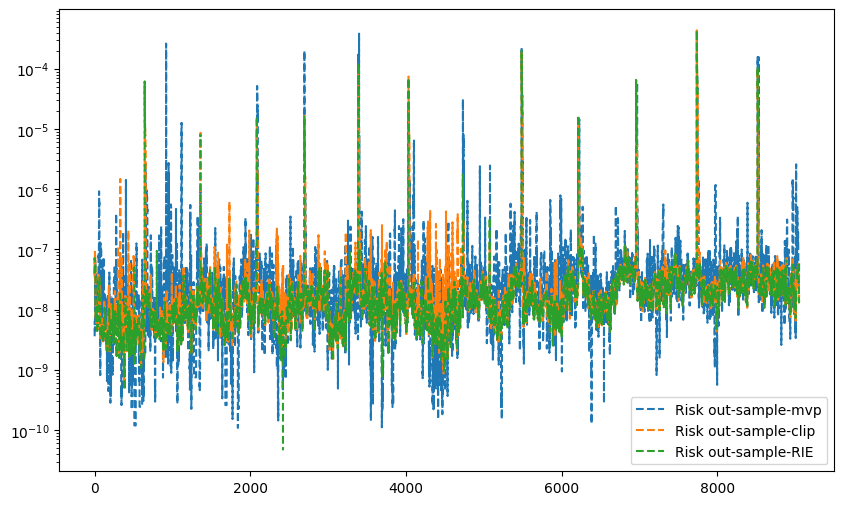

In [8]:
import matplotlib.pyplot as plt
risks_filled = risks_filled.filter(pl.col("out_sample_mvp") > 1e-10)
plt.figure(figsize=(10, 6))
plt.plot(risks_filled["out_sample_mvp"], label="Risk out-sample-mvp", linestyle="--")
plt.plot(risks_filled["out_sample_clip"], label="Risk out-sample-clip", linestyle="--")
plt.plot(risks_filled["out_sample_RIE"], label="Risk out-sample-RIE", linestyle="--")
plt.legend()
plt.yscale("log")
plt.show()